In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE

In [2]:
df = pd.read_csv('ev_charging_patterns.csv')
df.head(10)

,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type
0,User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,36.389181,13.087717,Evening,Tuesday,29.371576,86.119962,293.602111,27.947953,2.000000,DC Fast Charger,Commuter
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,21.128448,Morning,Monday,10.115778,84.664344,112.112804,14.311026,3.000000,Level 1,Casual Driver
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,35.667270,Morning,Thursday,6.854604,69.917615,71.799253,21.002002,2.000000,Level 2,Commuter
3,User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,32.882870,13.036239,Evening,Saturday,83.120003,99.624328,199.577785,38.316313,1.000000,Level 1,Long-Distance Traveler
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,10.161471,Morning,Saturday,54.258950,63.743786,203.661847,-7.834199,1.000000,Level 1,Long-Distance Traveler
5,User_6,Nissan Leaf,50.000000,Station_335,San Francisco,2024-01-01 05:00:00,2024-01-01 07:10:00,43.181137,1.167640,14.334523,36.900341,Evening,Saturday,75.217748,71.982288,143.680046,-5.274218,0.000000,DC Fast Charger,Long-Distance Traveler
6,User_7,Chevy Bolt,85.000000,Station_162,Houston,2024-01-01 06:00:00,2024-01-01 07:53:00,36.862140,3.539619,26.185188,22.214225,Evening,Friday,60.751781,70.796097,81.338009,27.551335,4.000000,Level 2,Commuter
7,User_8,Chevy Bolt,75.000000,Station_302,Los Angeles,2024-01-01 07:00:00,2024-01-01 10:42:00,51.467617,2.655396,26.702908,9.796821,Afternoon,Monday,56.201703,63.786815,116.543166,-4.417460,0.000000,Level 2,Long-Distance Traveler
8,User_9,Chevy Bolt,62.000000,Station_493,Los Angeles,2024-01-01 08:00:00,2024-01-01 09:21:00,43.592372,1.724204,14.294923,32.465005,Evening,Wednesday,33.466200,92.961421,208.259742,22.516706,4.000000,Level 1,Commuter
9,User_10,Hyundai Kona,50.000000,Station_452,Chicago,2024-01-01 09:00:00,2024-01-01 12:44:00,78.868607,2.026875,11.761000,21.312302,Morning,Wednesday,27.399455,70.053381,54.006309,27.512019,2.830381,DC Fast Charger,Commuter


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   User ID                                   1320 non-null   object 
 1   Vehicle Model                             1320 non-null   object 
 2   Battery Capacity (kWh)                    1320 non-null   float64
 3   Charging Station ID                       1320 non-null   object 
 4   Charging Station Location                 1320 non-null   object 
 5   Charging Start Time                       1320 non-null   object 
 6   Charging End Time                         1320 non-null   object 
 7   Energy Consumed (kWh)                     1254 non-null   float64
 8   Charging Duration (hours)                 1320 non-null   float64
 9   Charging Rate (kW)                        1254 non-null   float64
 10  Charging Cost (USD)                 

In [4]:
# 转换为时间变量
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'], errors='coerce')
df['Charging End Time'] = pd.to_datetime(df['Charging End Time'], errors='coerce')

# 转化为类型变量减小内存占用(净整没用的
categorical_columns = ['User Type', 'Vehicle Model', 'Charging Station Location', 'Time of Day', 'Day of Week', 'Charger Type']
for column in categorical_columns:
    df[column] = df[column].astype('category')


In [5]:
# 删除含空值的行，重复行
df = df.dropna()
df = df.drop_duplicates()

# 把电越充越少坏东西的删掉
df = df.drop(df[df['State of Charge (End %)'] < df['State of Charge (Start %)']].index)
    
# 把充满了的删掉（因为会影响我们不知道他实际充电时间了（比划
df = df[df['State of Charge (End %)'] <= 99]


In [6]:
# 构造新特征充电持续时间，不知道有啥用先搞了再说
df['Charging Duration_Cate'] = pd.cut(df['Charging Duration (hours)'],
                                          bins=[0, 1, 3, 6, np.inf],
                                          labels=['Short (<1 hr)', 'Medium (1-3 hrs)', 'Long (3-6 hrs)', 'Very Long (>6 hrs)'])

# Display count of different charging duration categories
print(df['Charging Duration_Cate'].value_counts())

df.info()

Charging Duration_Cate
Medium (1-3 hrs)      488
Long (3-6 hrs)        246
Short (<1 hr)         115
Very Long (>6 hrs)      2
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 851 entries, 0 to 1317
Data columns (total 21 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   User ID                                   851 non-null    object        
 1   Vehicle Model                             851 non-null    category      
 2   Battery Capacity (kWh)                    851 non-null    float64       
 3   Charging Station ID                       851 non-null    object        
 4   Charging Station Location                 851 non-null    category      
 5   Charging Start Time                       851 non-null    datetime64[ns]
 6   Charging End Time                         851 non-null    datetime64[ns]
 7   Energy Consumed (kWh)                  

In [7]:
# 用实际数据计算出实际的充电效率Charging Efficiency，啊这个啊很重要很重要要考的啊
df['Charging Efficiency'] = (((df['State of Charge (End %)'] - df['State of Charge (Start %)']) / 100) * df['Battery Capacity (kWh)']) / df['Charging Duration (hours)']

# 与原表中的理论值Charging Rate (kW)作比较
df['Loss'] = df['Charging Rate (kW)'] - df['Charging Efficiency']


In [8]:
# Remove obvious outliers in Charging Efficiency 去除极端的异常值
q1 = df['Charging Efficiency'].quantile(0.25)
q3 = df['Charging Efficiency'].quantile(0.75)
lower_bound = q1 - 1.5 * (q3 - q1)
upper_bound = q3 + 1.5 * (q3 - q1)
df = df[(df['Charging Efficiency'] >= lower_bound) & (df['Charging Efficiency'] <= upper_bound)]

# 把右侧Charging Rate太大的删掉
df = df[df['Charging Rate (kW)'] <= df['Charging Rate (kW)'].quantile(0.95)]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 760 entries, 1 to 1317
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   User ID                                   760 non-null    object        
 1   Vehicle Model                             760 non-null    category      
 2   Battery Capacity (kWh)                    760 non-null    float64       
 3   Charging Station ID                       760 non-null    object        
 4   Charging Station Location                 760 non-null    category      
 5   Charging Start Time                       760 non-null    datetime64[ns]
 6   Charging End Time                         760 non-null    datetime64[ns]
 7   Energy Consumed (kWh)                     760 non-null    float64       
 8   Charging Duration (hours)                 760 non-null    float64       
 9   Charging Rate (kW)                  

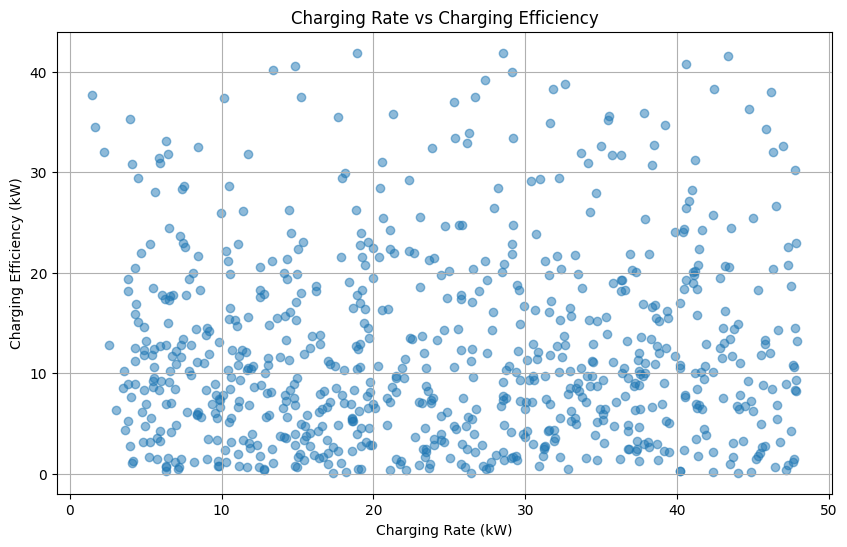

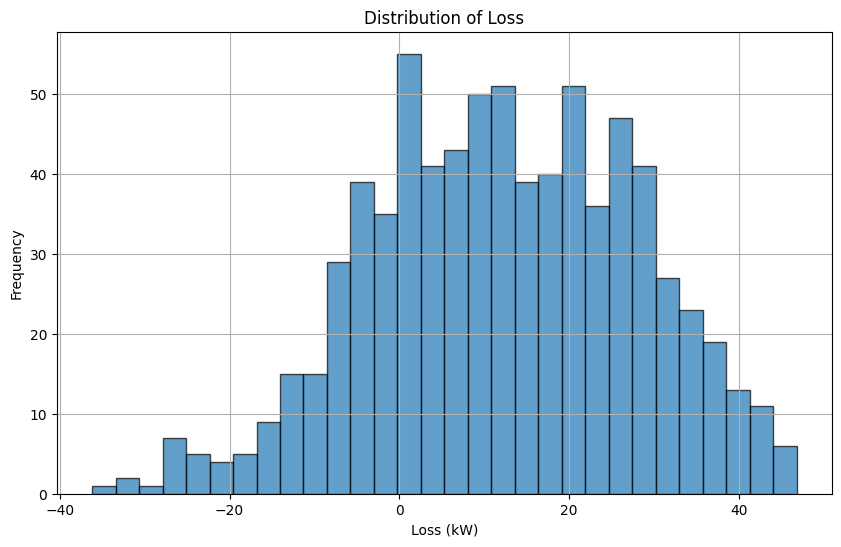

In [9]:
# Visualize Charging Rate vs Charging Efficiency 这个是他们俩的分布散点图
plt.figure(figsize=(10, 6))
plt.scatter(df['Charging Rate (kW)'], df['Charging Efficiency'], alpha=0.5)
plt.xlabel('Charging Rate (kW)')
plt.ylabel('Charging Efficiency (kW)')
plt.title('Charging Rate vs Charging Efficiency')
plt.grid(True)
plt.show()

# Visualize the distribution of Loss 画出loss图（loss是用充电功率-实际充进去的功率算的反正也不知道有没有道理 画了再说
plt.figure(figsize=(10, 6))
plt.hist(df['Loss'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Loss (kW)')
plt.ylabel('Frequency')
plt.title('Distribution of Loss')
plt.grid(True)
plt.show()

In [10]:
# 预处理就到这了，下面都是在乱搞

In [11]:
# 整体分析
features = ['Charging Duration (hours)', 'Time of Day', 'State of Charge (Start %)', 'State of Charge (End %)', 'Temperature (°C)', 'Vehicle Age (years)']
y_efficiency = df['Charging Efficiency']
X = df[features]
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y_efficiency, test_size=0.2, random_state=0)



In [12]:
# Linear Regression for Charging Efficiency 针对每小时充电效率的线性回归
from sklearn.model_selection import GridSearchCV
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

print(r2_score(y_test, y_pred_lin))

# Random Forest Regression for Charging Efficiency 针对每小时充电效率的随机森林回归
rf_reg = RandomForestRegressor(random_state=0)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)
print(r2_score(y_test, y_pred_rf))

0.6709825775938595
0.7922228139073508


In [13]:
# 我现在想的是目标变量：Charging Efficiency，特征：'Charging Duration (hours)', 'Time of Day'， 'State of Charge (Start %)', 'State of Charge (End %)', 'Temperature (°C)', 'Vehicle Age (years)'
# 先对所有数据整体分析，然后对分类对不同的Vehicle Model，User Type进行分类分析，比较类别之间的差异

In [14]:
df

,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),...,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type,Charging Duration_Cate,Charging Efficiency,Loss
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,...,10.115778,84.664344,112.112804,14.311026,3.0,Level 1,Casual Driver,Long (3-6 hrs),23.789676,6.888059
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,...,6.854604,69.917615,71.799253,21.002002,2.0,Level 2,Commuter,Medium (1-3 hrs),19.284124,8.229469
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,...,54.258950,63.743786,203.661847,-7.834199,1.0,Level 1,Long-Distance Traveler,Medium (1-3 hrs),2.348005,7.867707
6,User_7,Chevy Bolt,85.000000,Station_162,Houston,2024-01-01 06:00:00,2024-01-01 07:53:00,36.862140,3.539619,26.185188,...,60.751781,70.796097,81.338009,27.551335,4.0,Level 2,Commuter,Long (3-6 hrs),2.412030,23.773157
7,User_8,Chevy Bolt,75.000000,Station_302,Los Angeles,2024-01-01 07:00:00,2024-01-01 10:42:00,51.467617,2.655396,26.702908,...,56.201703,63.786815,116.543166,-4.417460,0.0,Level 2,Long-Distance Traveler,Medium (1-3 hrs),2.142367,24.560541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311,User_1312,Hyundai Kona,50.000000,Station_13,Houston,2024-02-24 15:00:00,2024-02-24 18:53:00,74.276701,2.849151,25.073544,...,41.344062,50.412341,194.793544,7.731967,3.0,Level 2,Commuter,Medium (1-3 hrs),1.591400,23.482144
1313,User_1314,Tesla Model 3,129.350616,Station_458,Chicago,2024-02-24 17:00:00,2024-02-24 19:35:00,60.725144,2.365991,10.491921,...,41.856825,94.097883,279.552278,-1.369994,3.0,Level 2,Long-Distance Traveler,Medium (1-3 hrs),28.560605,-18.068684
1315,User_1316,Nissan Leaf,100.000000,Station_57,New York,2024-02-24 19:00:00,2024-02-24 20:30:00,42.011654,1.426444,5.895475,...,39.204102,83.915952,239.601075,1.919655,7.0,DC Fast Charger,Commuter,Medium (1-3 hrs),31.344967,-25.449492
1316,User_1317,BMW i3,100.000000,Station_40,New York,2024-02-24 20:00:00,2024-02-24 20:44:00,68.185853,3.238212,18.388012,...,31.456375,93.096461,164.376022,34.029775,4.0,Level 2,Casual Driver,Long (3-6 hrs),19.035220,-0.647209


# 1.	From which dimensions can we describe Users' Charging Habits?
# 2.	How to define and calculate Charging Efficiency of Electric Vehicles?
# 3.	Is there a relation between them? If so, what factors might contribute?
# 4.	Are there any differences between the charging fee of different user and different locations. If so, what are the differences.

<class 'numpy.ndarray'>


C:\Users\kaleb\AppData\Local\Temp\ipykernel_1848\3920656290.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster["label of user"] = labels


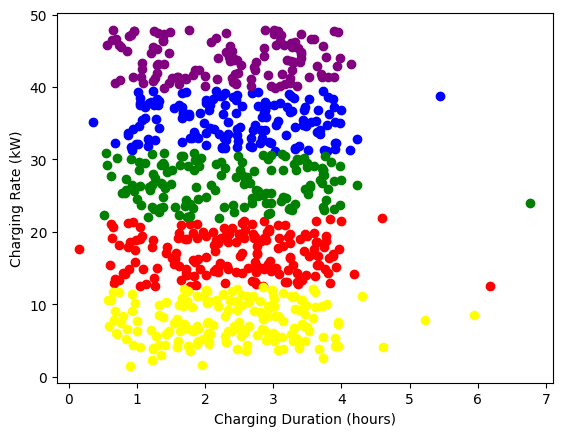

In [15]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

cluster = df.iloc[:, [8, 9]]


kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(cluster)


labels = kmeans.labels_
centroids = kmeans.cluster_centers_

print(type(labels))
cluster["label of user"] = labels

draw = cluster[(cluster["label of user"] == 0)]
plt.scatter(draw["Charging Duration (hours)"], draw["Charging Rate (kW)"], c="Red")

draw = cluster[(cluster["label of user"] == 1)]
plt.scatter(draw["Charging Duration (hours)"], draw["Charging Rate (kW)"], c="Blue")

draw = cluster[(cluster["label of user"] == 2)]
plt.scatter(draw["Charging Duration (hours)"], draw["Charging Rate (kW)"], c="Yellow")

draw = cluster[(cluster["label of user"] == 3)]
plt.scatter(draw["Charging Duration (hours)"], draw["Charging Rate (kW)"], c="Green")

draw = cluster[(cluster["label of user"] == 4)]
plt.scatter(draw["Charging Duration (hours)"], draw["Charging Rate (kW)"], c="Purple")

plt.xlabel("Charging Duration (hours)")
plt.ylabel("Charging Rate (kW)")
plt.show()

In [16]:
df
list = []
for label in labels:
    if label == 0:
        list.append("Red")
    elif label == 1:
        list.append("Blue")
    elif label == 2:
        list.append("Yellow")
    elif label == 3:
        list.append("Green")
    else:
        list.append("Black")

color = np.array(list)

resource = df.copy()
resource["label of user"] = labels
resource["color"] = color
resource

,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),...,Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type,Charging Duration_Cate,Charging Efficiency,Loss,label of user,color
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,...,112.112804,14.311026,3.0,Level 1,Casual Driver,Long (3-6 hrs),23.789676,6.888059,3,Green
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,...,71.799253,21.002002,2.0,Level 2,Commuter,Medium (1-3 hrs),19.284124,8.229469,3,Green
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,...,203.661847,-7.834199,1.0,Level 1,Long-Distance Traveler,Medium (1-3 hrs),2.348005,7.867707,2,Yellow
6,User_7,Chevy Bolt,85.000000,Station_162,Houston,2024-01-01 06:00:00,2024-01-01 07:53:00,36.862140,3.539619,26.185188,...,81.338009,27.551335,4.0,Level 2,Commuter,Long (3-6 hrs),2.412030,23.773157,3,Green
7,User_8,Chevy Bolt,75.000000,Station_302,Los Angeles,2024-01-01 07:00:00,2024-01-01 10:42:00,51.467617,2.655396,26.702908,...,116.543166,-4.417460,0.0,Level 2,Long-Distance Traveler,Medium (1-3 hrs),2.142367,24.560541,3,Green
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311,User_1312,Hyundai Kona,50.000000,Station_13,Houston,2024-02-24 15:00:00,2024-02-24 18:53:00,74.276701,2.849151,25.073544,...,194.793544,7.731967,3.0,Level 2,Commuter,Medium (1-3 hrs),1.591400,23.482144,3,Green
1313,User_1314,Tesla Model 3,129.350616,Station_458,Chicago,2024-02-24 17:00:00,2024-02-24 19:35:00,60.725144,2.365991,10.491921,...,279.552278,-1.369994,3.0,Level 2,Long-Distance Traveler,Medium (1-3 hrs),28.560605,-18.068684,2,Yellow
1315,User_1316,Nissan Leaf,100.000000,Station_57,New York,2024-02-24 19:00:00,2024-02-24 20:30:00,42.011654,1.426444,5.895475,...,239.601075,1.919655,7.0,DC Fast Charger,Commuter,Medium (1-3 hrs),31.344967,-25.449492,2,Yellow
1316,User_1317,BMW i3,100.000000,Station_40,New York,2024-02-24 20:00:00,2024-02-24 20:44:00,68.185853,3.238212,18.388012,...,164.376022,34.029775,4.0,Level 2,Casual Driver,Long (3-6 hrs),19.035220,-0.647209,0,Red


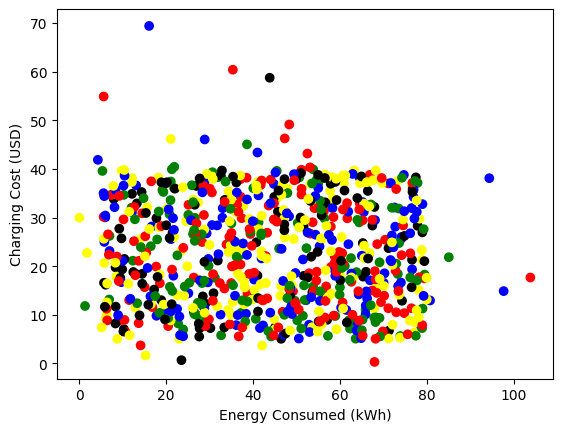

In [17]:
plt.scatter(resource["Energy Consumed (kWh)"], resource["Charging Cost (USD)"], c= resource["color"])
plt.xlabel("Energy Consumed (kWh)")
plt.ylabel("Charging Cost (USD)")
plt.show()

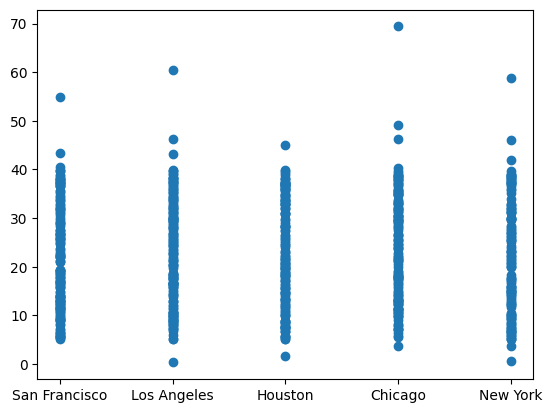

In [18]:
plt.scatter(resource["Charging Station Location"], resource["Charging Cost (USD)"])
plt.show()

In [19]:
condition = [resource["Charging Station Location"] == "San Francisco",
             resource["Charging Station Location"] == "Los Angeles",
             resource["Charging Station Location"] == "Houston",
             resource["Charging Station Location"] == "Chicago",
             resource["Charging Station Location"] == "New York"]
choice = ['red', 'green', 'blue', 'orange', 'purple']

resource = df.copy()

resource["color"] = np.select(condition, choice)
resource

,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),...,State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type,Charging Duration_Cate,Charging Efficiency,Loss,color
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,...,84.664344,112.112804,14.311026,3.0,Level 1,Casual Driver,Long (3-6 hrs),23.789676,6.888059,red
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,...,69.917615,71.799253,21.002002,2.0,Level 2,Commuter,Medium (1-3 hrs),19.284124,8.229469,red
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,...,63.743786,203.661847,-7.834199,1.0,Level 1,Long-Distance Traveler,Medium (1-3 hrs),2.348005,7.867707,green
6,User_7,Chevy Bolt,85.000000,Station_162,Houston,2024-01-01 06:00:00,2024-01-01 07:53:00,36.862140,3.539619,26.185188,...,70.796097,81.338009,27.551335,4.0,Level 2,Commuter,Long (3-6 hrs),2.412030,23.773157,blue
7,User_8,Chevy Bolt,75.000000,Station_302,Los Angeles,2024-01-01 07:00:00,2024-01-01 10:42:00,51.467617,2.655396,26.702908,...,63.786815,116.543166,-4.417460,0.0,Level 2,Long-Distance Traveler,Medium (1-3 hrs),2.142367,24.560541,green
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311,User_1312,Hyundai Kona,50.000000,Station_13,Houston,2024-02-24 15:00:00,2024-02-24 18:53:00,74.276701,2.849151,25.073544,...,50.412341,194.793544,7.731967,3.0,Level 2,Commuter,Medium (1-3 hrs),1.591400,23.482144,blue
1313,User_1314,Tesla Model 3,129.350616,Station_458,Chicago,2024-02-24 17:00:00,2024-02-24 19:35:00,60.725144,2.365991,10.491921,...,94.097883,279.552278,-1.369994,3.0,Level 2,Long-Distance Traveler,Medium (1-3 hrs),28.560605,-18.068684,orange
1315,User_1316,Nissan Leaf,100.000000,Station_57,New York,2024-02-24 19:00:00,2024-02-24 20:30:00,42.011654,1.426444,5.895475,...,83.915952,239.601075,1.919655,7.0,DC Fast Charger,Commuter,Medium (1-3 hrs),31.344967,-25.449492,purple
1316,User_1317,BMW i3,100.000000,Station_40,New York,2024-02-24 20:00:00,2024-02-24 20:44:00,68.185853,3.238212,18.388012,...,93.096461,164.376022,34.029775,4.0,Level 2,Casual Driver,Long (3-6 hrs),19.035220,-0.647209,purple


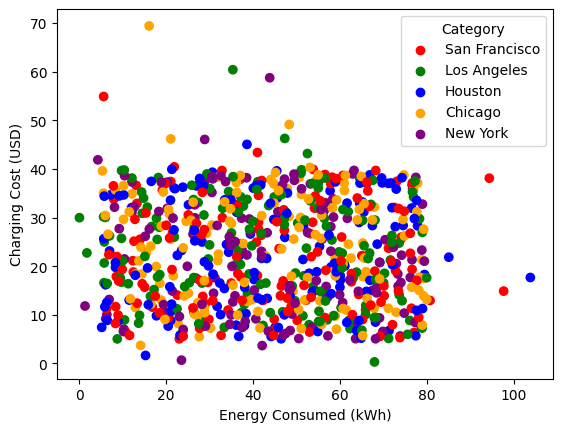

In [27]:
legend_elements = []
unique_categories = resource[["Charging Station Location", "color"]].drop_duplicates()
for _, row in unique_categories.iterrows():
    plt.scatter([], [], color=row["color"], label=row["Charging Station Location"])

plt.scatter(resource["Energy Consumed (kWh)"], resource["Charging Cost (USD)"], c=resource["color"])
plt.xlabel("Energy Consumed (kWh)")
plt.ylabel("Charging Cost (USD)")
plt.legend(title="Category", loc="upper right")
plt.show()

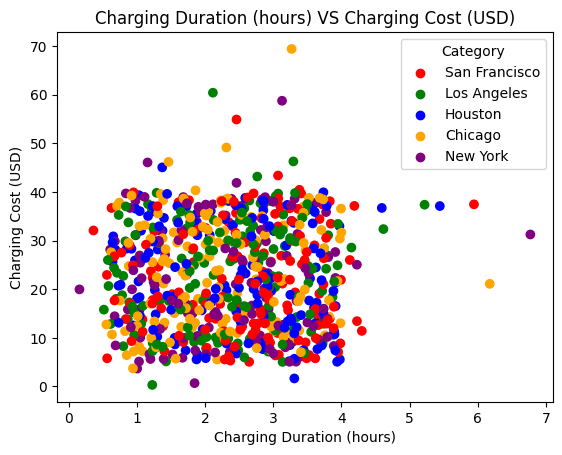

In [30]:
legend_elements = []
unique_categories = resource[["Charging Station Location", "color"]].drop_duplicates()
for _, row in unique_categories.iterrows():
    plt.scatter([], [], color=row["color"], label=row["Charging Station Location"])


plt.scatter(resource["Charging Duration (hours)"], resource["Charging Cost (USD)"], c=resource["color"])
plt.title("Charging Duration (hours) VS Charging Cost (USD)")
plt.xlabel("Charging Duration (hours)")
plt.ylabel("Charging Cost (USD)")
plt.legend(title="Category", loc="upper right")
plt.show()